In [72]:
import re

import pandas as pd
import seaborn as sns

from router_poc import settings as S

In [73]:
suite_path = S.DATA_DIR / "raw" / "crfm-helm-public" / "mmlu" / "benchmark_output" / "runs"

In [74]:
evals = list(path for path in suite_path.glob("*/*") if path.is_dir())
len(evals)

4632

In [75]:
models = []
for path in evals:
    model_name = re.search(r"model=(.*?),", path.name).group(1)
    models.append(model_name)

models = pd.Series(models)
models.value_counts()


nvidia_nemotron-4-340b-instruct             114
anthropic_claude-3-sonnet-20240229           62
anthropic_claude-3-opus-20240229             62
meta_llama-3.2-90b-vision-instruct-turbo     57
qwen_qwen2.5-7b-instruct-turbo               57
                                           ... 
google_gemini-1.5-flash-002                  57
upstage_solar-pro-241126                     57
anthropic_claude-3-5-sonnet-20241022         57
meta_llama-3.3-70b-instruct-turbo            57
google_gemini-pro                             5
Name: count, Length: 81, dtype: int64

In [76]:
providers = ["google", "openai", "anthropic", "mistral"]

models = models[models.str.startswith(tuple(providers))]
models = models[models.isin(models.value_counts()[models.value_counts() > 50].index)]
models.value_counts()

anthropic_claude-3-opus-20240229        62
anthropic_claude-3-sonnet-20240229      62
google_gemini-1.5-flash-001             57
mistralai_mistral-7b-instruct-v0.3      57
google_gemini-1.5-pro-001               57
google_gemma-2-27b                      57
openai_gpt-4-turbo-2024-04-09           57
google_gemini-2.0-flash-exp             57
google_gemma-2-9b                       57
openai_gpt-4-1106-preview               57
anthropic_claude-2.1                    57
mistralai_mixtral-8x7b-32kseqlen        57
anthropic_claude-3-5-haiku-20241022     57
openai_gpt-3.5-turbo-0613               57
openai_gpt-4-0613                       57
anthropic_claude-instant-1.2            57
google_gemini-1.0-pro-001               57
google_text-unicorn@001                 57
mistralai_mistral-7b-v0.1               57
google_text-bison@001                   57
anthropic_claude-3-haiku-20240307       57
google_gemma-7b                         57
mistralai_mixtral-8x22b                 57
google_gemi

In [77]:
selected_models = [
    "mistralai_mistral-small-2402",
    "mistralai_mistral-large-2407",
    "openai_gpt-4o-2024-08-06",
    "anthropic_claude-3-5-sonnet-20241022",
    "anthropic_claude-3-5-haiku-20241022",
    "openai_gpt-4-turbo-2024-04-09",
    "google_gemini-2.0-flash-exp"
]

In [78]:
evals[0].name

'mmlu:subject=public_relations,method=multiple_choice_joint,model=meta_llama-3.2-90b-vision-instruct-turbo,eval_split=test,groups=mmlu_public_relations'

In [79]:
evals_subset = []
for eval in evals:
    for model in selected_models:
        if model in eval.name:
            evals_subset.append(eval)

display(len(evals_subset))

evals_subset[0].name

399

'mmlu:subject=college_medicine,method=multiple_choice_joint,model=openai_gpt-4-turbo-2024-04-09,eval_split=test,groups=mmlu_college_medicine'

In [80]:
dfs = []
for eval in evals_subset:
    predictions = pd.read_json(eval / "display_predictions.json")
    predictions = pd.concat([predictions, pd.json_normalize(predictions["stats"])], axis=1)
    predictions = predictions[["exact_match"]]
    prompts = pd.read_json(eval / "display_requests.json")
    prompts = pd.concat([prompts, pd.json_normalize(prompts["request"])], axis=1)
    prompts = prompts[["prompt", "model"]]
    assert prompts.model.nunique() == 1
    results = pd.concat([prompts, predictions], axis=1)
    results["provider"] = prompts.model.str.split("/").str[0]
    dfs.append(results)

df = pd.concat(dfs, ignore_index=True)
df

,prompt,model,exact_match,provider
0,Answer with only a single letter.\n\nThe follo...,openai/gpt-4-turbo-2024-04-09,1.0,openai
1,Answer with only a single letter.\n\nThe follo...,openai/gpt-4-turbo-2024-04-09,1.0,openai
2,Answer with only a single letter.\n\nThe follo...,openai/gpt-4-turbo-2024-04-09,1.0,openai
3,Answer with only a single letter.\n\nThe follo...,openai/gpt-4-turbo-2024-04-09,1.0,openai
4,Answer with only a single letter.\n\nThe follo...,openai/gpt-4-turbo-2024-04-09,0.0,openai
...,...,...,...,...
98289,Answer with only a single letter.\n\nThe follo...,anthropic/claude-3-5-sonnet-20241022,1.0,anthropic
98290,Answer with only a single letter.\n\nThe follo...,anthropic/claude-3-5-sonnet-20241022,1.0,anthropic
98291,Answer with only a single letter.\n\nThe follo...,anthropic/claude-3-5-sonnet-20241022,1.0,anthropic
98292,Answer with only a single letter.\n\nThe follo...,anthropic/claude-3-5-sonnet-20241022,1.0,anthropic


In [81]:
df.exact_match.mean()

np.float64(0.797617352025556)

In [82]:
df.prompt.nunique()

28030

<Axes: xlabel='count', ylabel='Count'>

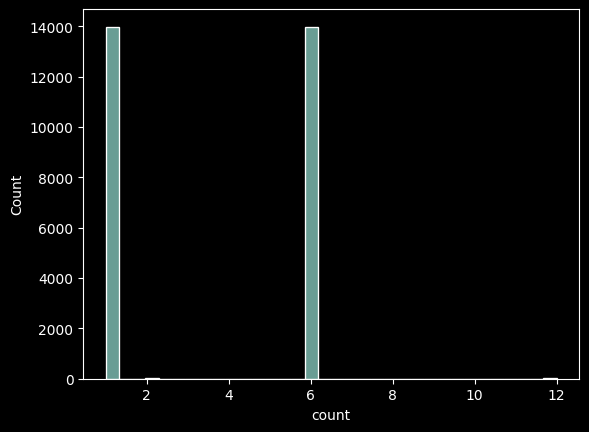

In [83]:
sns.histplot(df.prompt.value_counts())

I have 7 models under test, so I was expecting each prompt to repeat 7 times. Seems like they modified prompt for one of the models, I'll just drop it for now.

In [84]:
min_count_prompt = df.prompt.value_counts().index[-1]
min_count_prompt

'The following are multiple choice questions (with answers) about conceptual physics.\n\nQuestion: A model airplane flies slower when flying into the wind and faster with wind at its back. When launched at right angles to the wind a cross wind its groundspeed compared with flying in still air is\nA. the same\nB. greater\nC. less\nD. either greater or less depending on wind speed\nAnswer: B\n\nQuestion: Things that are equivalent according to the equivalence principle are\nA. space and time.\nB. a traveling twin and a stay-at-home twin.\nC. gravity and acceleration.\nD. mass and energy.\nAnswer: C\n\nQuestion: Which of these three elements has the most mass per nucleon?\nA. Hydrogen\nB. Iron\nC. Uranium\nD. Same in each\nAnswer: A\n\nQuestion: Compared with the mass of a uranium atom undergoing fission, the combined masses of the products after fission are\nA. less\nB. more\nC. the same\nD. zero\nAnswer: A\n\nQuestion: Colors in a soap bubble result from light\nA. converted to a differe

In [85]:
df.query("prompt == @min_count_prompt")

,prompt,model,exact_match,provider
46809,The following are multiple choice questions (w...,mistralai/mistral-small-2402,0.0,mistralai


In [86]:
df.query("model != 'mistralai/mistral-small-2402'").prompt.value_counts().describe()

count    14015.000000
mean         6.011559
std          0.263108
min          6.000000
25%          6.000000
50%          6.000000
75%          6.000000
max         12.000000
Name: count, dtype: float64

In [90]:
df = df.query("model != 'mistralai/mistral-small-2402'")
df.shape

(84252, 4)

In [91]:
df.prompt.value_counts().describe()

count    14015.000000
mean         6.011559
std          0.263108
min          6.000000
25%          6.000000
50%          6.000000
75%          6.000000
max         12.000000
Name: count, dtype: float64

In [92]:
df.to_parquet(S.DATA_DIR / "intermediate" / "stanford_mmlu_results.parquet")